Loading data from: ../data/02_intermediate\01_merged_data.csv
Successfully loaded merged data.

--- Merged Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
 10  N_SOIL           19689 non-null  float64
 11  P_SOIL           19689 non-null  float64
 12  K_SOIL           19689 non-null  float64
 13  pH_SOIL          19689 non-null  float64
dtypes: float64(9), int64(2), obje

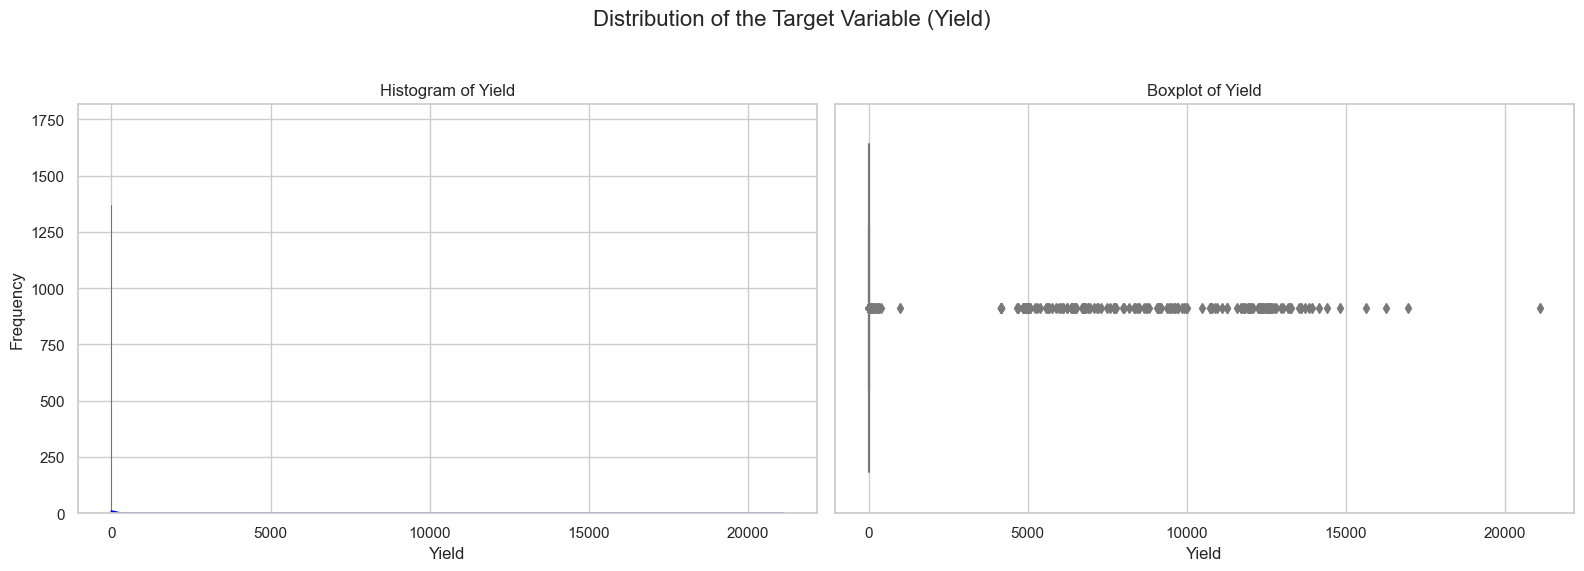


Yield Statistics:
count    19689.000000
mean        79.954009
std        878.306193
min          0.000000
25%          0.600000
50%          1.030000
75%          2.388889
max      21105.000000
Name: Yield, dtype: float64

Number of rows with Yield < 0.01: 113
Percentage of rows with Yield < 0.01: 0.57%

NOTE: The Yield distribution is highly skewed (long tail to the right).
This is common. We will proceed, but for advanced models, a log-transform (np.log1p) might be considered.

--- Analyzing Categorical Features ---
Total unique 'Crop' types: 55
Total unique 'Season' types: 6
Total unique 'State' types: 30

Unique 'Season' values:
['Whole Year ' 'Kharif     ' 'Rabi       ' 'Autumn     ' 'Summer     '
 'Winter     ']

Step 1 (Load & Initial Analysis) is complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline 

# --- 1. Define File Paths ---
PROCESSED_DATA_DIR = "../data/02_intermediate"
MERGED_DATA_PATH = os.path.join(PROCESSED_DATA_DIR, "01_merged_data.csv")

# NEW: Define path for saving figures
FIGURES_DIR = "../04_reports/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)
YIELD_DIST_FIG_PATH = os.path.join(FIGURES_DIR, "01_yield_distribution.png")


# --- 2. Load the Merged Data ---
print(f"Loading data from: {MERGED_DATA_PATH}")

try:
    df = pd.read_csv(MERGED_DATA_PATH)
    print("Successfully loaded merged data.")
except FileNotFoundError:
    print(f"ERROR: File not found at {MERGED_DATA_PATH}")
    print("Please make sure you have run the Milestone 1 notebook successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

if 'df' in locals():
    print("\n--- Merged Data Info ---")
    df.info()

    # --- 3. Analyze Target Variable (Yield) ---
    print("\n--- Analyzing Target Variable: 'Yield' ---")

    # Set plot style
    sns.set(style="whitegrid")

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Distribution of the Target Variable (Yield)", fontsize=16)

    # Plot 1: Histogram
    sns.histplot(df['Yield'], kde=True, ax=axes[0], color='blue')
    axes[0].set_title('Histogram of Yield')
    axes[0].set_xlabel('Yield')
    axes[0].set_ylabel('Frequency')

    # Plot 2: Boxplot
    sns.boxplot(x=df['Yield'], ax=axes[1], color='lightblue')
    axes[1].set_title('Boxplot of Yield')
    axes[1].set_xlabel('Yield')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # NEW: Save the figure to the reports folder
    try:
        fig.savefig(YIELD_DIST_FIG_PATH)
        print(f"\nPlot saved successfully to: {YIELD_DIST_FIG_PATH}")
    except Exception as e:
        print(f"\nError saving plot: {e}")
    
    # This command will now work correctly thanks to %matplotlib inline
    plt.show()

    # Get statistics
    print("\nYield Statistics:")
    print(df['Yield'].describe())
    
    # Check for zero or near-zero yields
    zero_yield_count = (df['Yield'] < 0.01).sum()
    print(f"\nNumber of rows with Yield < 0.01: {zero_yield_count}")
    print(f"Percentage of rows with Yield < 0.01: {(zero_yield_count / len(df) * 100):.2f}%")
    
    print("\nNOTE: The Yield distribution is highly skewed (long tail to the right).")
    print("This is common. We will proceed, but for advanced models, a log-transform (np.log1p) might be considered.")


    # --- 4. Analyze Categorical Columns ---
    print("\n--- Analyzing Categorical Features ---")

    # Get unique counts
    print(f"Total unique 'Crop' types: {df['Crop'].nunique()}")
    print(f"Total unique 'Season' types: {df['Season'].nunique()}")
    print(f"Total unique 'State' types: {df['State'].nunique()}")

    print("\nUnique 'Season' values:")
    print(df['Season'].unique())
    
    print("\nStep 1 (Load & Initial Analysis) is complete.")

else:
    print("\n--- Data not loaded. Halting execution. ---")

In [2]:
from sklearn.preprocessing import LabelEncoder
import json
import os # os was imported in the cell above, but re-importing is safe

print("\n--- Executing Step 2: Feature Engineering ---")

# This code assumes 'df' DataFrame exists in memory from the previous cell.

# --- 2.1. Handle Data Leakage (CRITICAL) ---
print("Addressing data leakage...")
print("Dropping 'Production' and 'Area' columns.")
print("Reason: 'Yield' is directly calculated from them (Yield = Production / Area).")
print("Keeping them would lead to a model that 'cheats' and has perfect, but useless, scores.")

# Check if columns exist before dropping
cols_to_drop = ['Production', 'Area']
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

if existing_cols_to_drop:
    df.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Successfully dropped: {existing_cols_to_drop}")
else:
    print("'Production' and 'Area' columns were already removed.")


# --- 2.2. Encode Categorical Features ---
print("\nEncoding categorical features (Crop, Season, State)...")

# Initialize encoders
le_crop = LabelEncoder()
le_season = LabelEncoder()
le_state = LabelEncoder()

# Fit and transform the data, creating new columns
df['Crop_encoded'] = le_crop.fit_transform(df['Crop'])
df['Season_encoded'] = le_season.fit_transform(df['Season'])
df['State_encoded'] = le_state.fit_transform(df['State'])

print("Categorical features successfully encoded.")


# --- 2.3. Save Encodings for Later Use (Milestone 4) ---
# We must save these mappings to translate user input in the web app.
MODELS_DIR = "../05_models"
ENCODINGS_PATH = os.path.join(MODELS_DIR, "categorical_encodings.json")

# Ensure the '05_models' directory exists
os.makedirs(MODELS_DIR, exist_ok=True)

# Create dictionaries (maps) of the encodings
# We convert the numpy array from '.classes_' to a simple list() to make it JSON-serializable
encodings = {
    'Crop': list(le_crop.classes_),
    'Season': list(le_season.classes_),
    'State': list(le_state.classes_)
}

# Write the mappings to a JSON file
try:
    with open(ENCODINGS_PATH, 'w') as f:
        json.dump(encodings, f, indent=4)
    print(f"\nSuccessfully saved encoding maps to: {ENCODINGS_PATH}")
    print("(This file is essential for the web app in Milestone 4)")
except Exception as e:
    print(f"\nError saving encoding maps: {e}")


# --- 2.4. Show Result ---
print("\nDataFrame head after feature engineering (note the new '_encoded' columns):")
print(df.head())

print("\nStep 2 (Feature Engineering) is complete.")


--- Executing Step 2: Feature Engineering ---
Addressing data leakage...
Dropping 'Production' and 'Area' columns.
Reason: 'Yield' is directly calculated from them (Yield = Production / Area).
Keeping them would lead to a model that 'cheats' and has perfect, but useless, scores.
Successfully dropped: ['Production', 'Area']

Encoding categorical features (Crop, Season, State)...
Categorical features successfully encoded.

Successfully saved encoding maps to: ../05_models\categorical_encodings.json
(This file is essential for the web app in Milestone 4)

DataFrame head after feature engineering (note the new '_encoded' columns):
           Crop  Crop_Year       Season  State  Annual_Rainfall  Fertilizer  \
0      Arecanut       1997  Whole Year   Assam           2051.4  7024878.38   
1     Arhar/Tur       1997  Kharif       Assam           2051.4   631643.29   
2   Castor seed       1997  Kharif       Assam           2051.4    75755.32   
3      Coconut        1997  Whole Year   Assam  


--- Executing Step 3 (CORRECTION) ---
Selecting ALL numerical features (float64, int64, int32)...
Dropped 'Crop_Year' from heatmap.
Final columns for heatmap: ['Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield', 'N_SOIL', 'P_SOIL', 'K_SOIL', 'pH_SOIL', 'Crop_encoded', 'Season_encoded', 'State_encoded']
Generating *corrected* correlation heatmap...

Corrected heatmap saved successfully to: ../04_reports/figures\02_correlation_heatmap.png


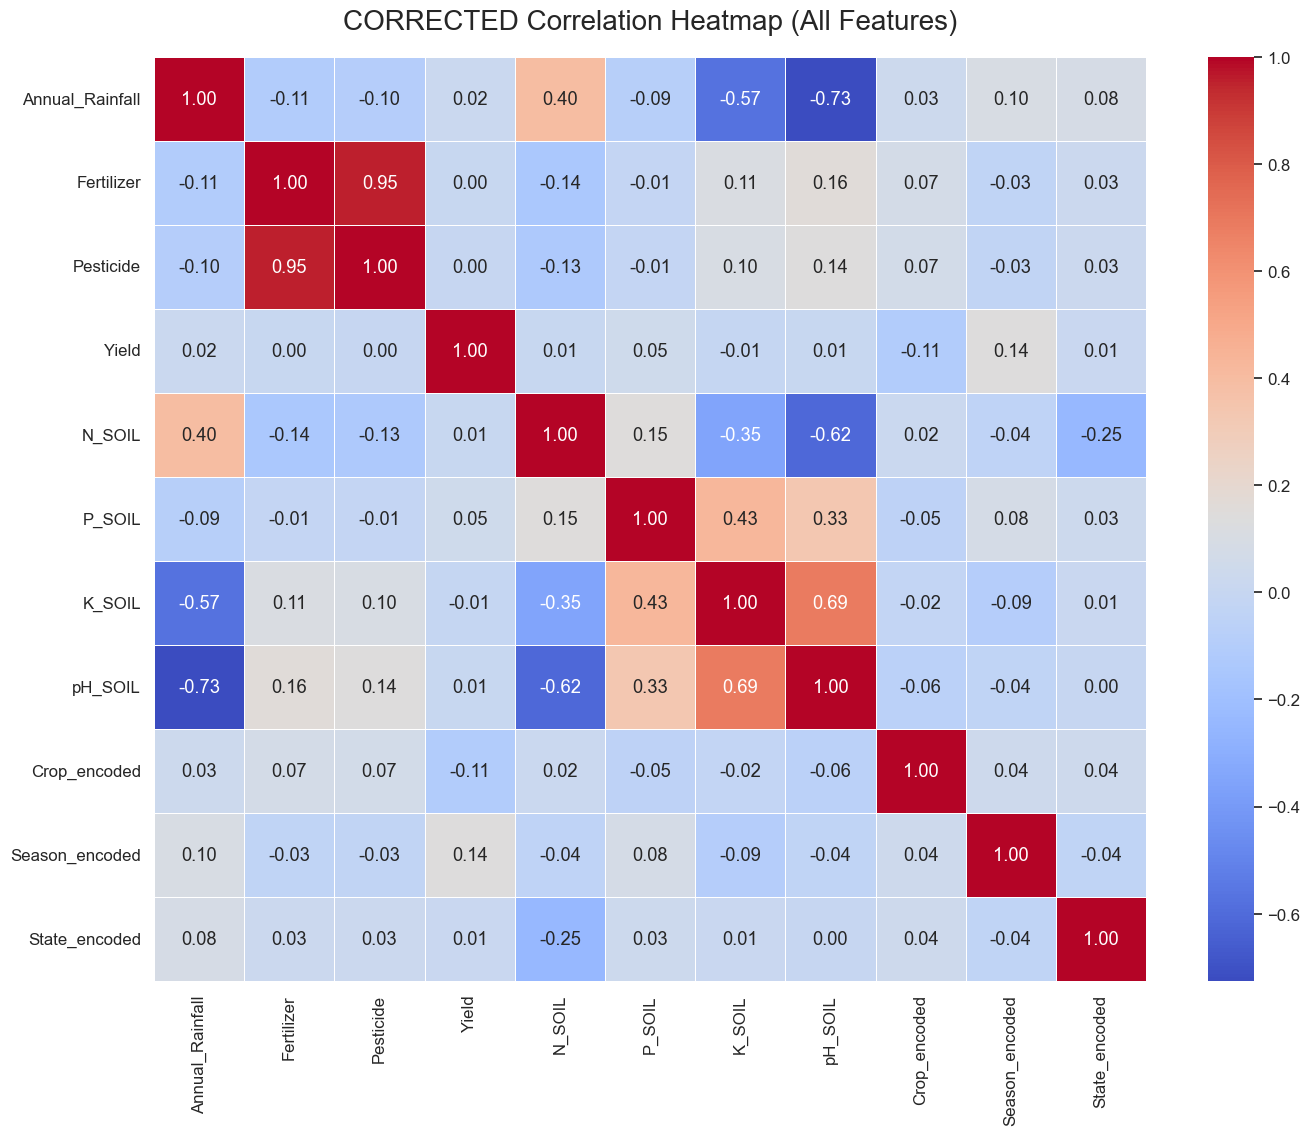


--- CORRECTED Correlation Analysis with Target (Yield) ---
Features and their correlation with 'Yield':
Yield              1.000000
Season_encoded     0.141791
P_SOIL             0.047147
Annual_Rainfall    0.020761
State_encoded      0.009668
N_SOIL             0.008940
pH_SOIL            0.007680
Fertilizer         0.002862
Pesticide          0.001782
K_SOIL            -0.010387
Crop_encoded      -0.110894
Name: Yield, dtype: float64

Most Positively Correlated Features:
Yield             1.000000
Season_encoded    0.141791
Name: Yield, dtype: float64

Most Negatively Correlated Features:
Crop_encoded   -0.110894
Name: Yield, dtype: float64

Step 3 (Correction) is complete. We can now proceed to Step 4.


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import os # Already imported, but good practice
import numpy as np # Import numpy

print("\n--- Executing Step 3 (CORRECTION) ---")

# This code assumes 'df' DataFrame exists in memory from the previous cell.

# --- 3.1. Select ALL Numerical Columns for Correlation ---
# We will drop the original text columns as they cannot be used in a heatmap
print("Selecting ALL numerical features (float64, int64, int32)...")

# --- THIS IS THE FIX ---
# We now include np.number to select ALL numeric types (float, int32, int64)
# We also drop 'Crop_Year' as it's a time-series element, not a direct predictor.
numerical_df = df.select_dtypes(include=[np.number])

if 'Crop_Year' in numerical_df.columns:
    numerical_df = numerical_df.drop(columns=['Crop_Year'])
    print("Dropped 'Crop_Year' from heatmap.")

print("Final columns for heatmap:", numerical_df.columns.tolist())

# --- 3.2. Generate and Plot Correlation Heatmap ---
print("Generating *corrected* correlation heatmap...")

plt.figure(figsize=(16, 12))
sns.set(font_scale=1.1) 

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Create the heatmap
heatmap = sns.heatmap(
    corr_matrix, 
    annot=True,     
    cmap='coolwarm',
    fmt=".2f",      # Format annotations to 2 decimal places
    linewidths=.5   
)

heatmap.set_title('CORRECTED Correlation Heatmap (All Features)', fontsize=20, pad=20)

# --- 3.3. Save the Heatmap ---
# We will overwrite the old, incorrect heatmap
CORR_HEATMAP_FIG_PATH = os.path.join(FIGURES_DIR, "02_correlation_heatmap.png")

try:
    plt.savefig(CORR_HEATMAP_FIG_PATH, bbox_inches='tight') 
    print(f"\nCorrected heatmap saved successfully to: {CORR_HEATMAP_FIG_PATH}")
except Exception as e:
    print(f"\nError saving heatmap: {e}")

# Show the plot in the notebook
plt.show()

# --- 3.4. Analyze Correlations with 'Yield' (FIXED) ---
print("\n--- CORRECTED Correlation Analysis with Target (Yield) ---")

try:
    # Get correlation values with 'Yield', sort them
    yield_corr = corr_matrix['Yield'].sort_values(ascending=False)
    
    print("Features and their correlation with 'Yield':")
    print(yield_corr)
    
    # --- THIS IS THE FIX for the NameError ---
    print("\nMost Positively Correlated Features:")
    print(yield_corr[yield_corr > 0.05]) # Show features with > 5% positive correlation
    
    print("\nMost Negatively Correlated Features:")
    print(yield_corr[yield_corr < -0.05]) # Show features with > 5% negative correlation

except KeyError:
    print("\nError: 'Yield' column not found in correlation matrix.")
except Exception as e:
    print(f"\nAn error occurred during correlation analysis: {e}")


print("\nStep 3 (Correction) is complete. We can now proceed to Step 4.")

In [5]:
from sklearn.model_selection import train_test_split
import os # Already imported

print("\n--- Executing Step 4: Feature Selection & Finalization ---")

# This code assumes 'df' DataFrame exists in memory from the previous cell.

# --- 4.1. Define Final Features (X) and Target (y) ---
print("Defining final feature set (X) and target (y)...")

# Our target (y) is the 'Yield' column
y = df['Yield']

# Our features (X) are all the predictive columns.
# We must drop the original text columns and the target 'Yield'.
features_to_drop = ['Crop', 'Season', 'State', 'Yield']
X = df.drop(columns=features_to_drop)

print("Target variable (y) shape:", y.shape)
print("Feature matrix (X) shape:", X.shape)
print("\nFinal features included in X:")
print(X.columns.tolist())

# --- 4.2. Split Data into Training and Testing Sets ---
print("\nSplitting data into training (80%) and testing (20%) sets...")

# We use train_test_split from scikit-learn
# test_size=0.2 means 20% of data is reserved for testing
# random_state=42 is a fixed number that ensures our split is reproducible.
# This is a best practice.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- 4.3. Save the Split Datasets ---
print("\nSaving split datasets to '02_intermediate' folder...")
PROCESSED_DATA_DIR = "../data/02_intermediate"

try:
    X_train.to_csv(os.path.join(PROCESSED_DATA_DIR, "X_train.csv"), index=False)
    X_test.to_csv(os.path.join(PROCESSED_DATA_DIR, "X_test.csv"), index=False)
    y_train.to_csv(os.path.join(PROCESSED_DATA_DIR, "y_train.csv"), index=False)
    y_test.to_csv(os.path.join(PROCESSED_DATA_DIR, "y_test.csv"), index=False)
    
    print("All 4 data splits (X_train, X_test, y_train, y_test) saved successfully.")
    
except Exception as e:
    print(f"\nError saving data splits: {e}")

print("\n--- MILESTONE 2 COMPLETE ---")
print("We have successfully performed EDA, engineered features,")
print("and prepared the data for modeling.")


--- Executing Step 4: Feature Selection & Finalization ---
Defining final feature set (X) and target (y)...
Target variable (y) shape: (19689,)
Feature matrix (X) shape: (19689, 11)

Final features included in X:
['Crop_Year', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'N_SOIL', 'P_SOIL', 'K_SOIL', 'pH_SOIL', 'Crop_encoded', 'Season_encoded', 'State_encoded']

Splitting data into training (80%) and testing (20%) sets...
X_train shape: (15751, 11)
X_test shape: (3938, 11)
y_train shape: (15751,)
y_test shape: (3938,)

Saving split datasets to '02_intermediate' folder...
All 4 data splits (X_train, X_test, y_train, y_test) saved successfully.

--- MILESTONE 2 COMPLETE ---
We have successfully performed EDA, engineered features,
and prepared the data for modeling.
